In [377]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt

In [378]:
tickers = ['AZN', 'GSK', 'HSBA', 'BP', 'SHEL', 'BARC', 'LSEG', 'RIO', 'BATS', 'REL', 'DGE']
tickers = [ticker + '.L' for ticker in tickers]

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(1*365)

returnsData = yf.download(tickers,start=startDate,end=endDate,interval='1d')
returnsData = returnsData['Adj Close']

[*********************100%***********************]  11 of 11 completed


In [379]:
portfolioReturns = returnsData.pct_change().dropna()

/var/folders/33/_ft973790qv2wpzyrpc3p2fr0000gn/T/ipykernel_94522/670730958.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  portfolioReturns = returnsData.pct_change().dropna()


In [380]:
class MeanVarianceOptimisation:
    def __init__(self, portfolioReturns, numPortfolios=10000, riskFreeRate=0.04):
        self.portfolioReturns = portfolioReturns
        self.meanReturns = portfolioReturns.mean()
        self.covReturns = portfolioReturns.cov()
        self.numPortfolios = numPortfolios
        self.numStocks = len(portfolioReturns.columns)
        self.results = np.zeros((3, numPortfolios))
        self.weights = np.zeros((self.numStocks, numPortfolios))
        self.riskFreeRate = riskFreeRate
        self.tickers = np.array(portfolioReturns.columns)
    
    
    def generatePortfolios(self):
        for j in range(self.numPortfolios):
            randomWeights = np.random.random(self.numStocks)
            randomWeights /= np.sum(randomWeights)
            self.weights[:,j] = randomWeights
            pfReturns = np.sum(self.meanReturns*randomWeights) * 252
            portfolioStdev = np.sqrt(np.dot(randomWeights.T, np.dot(self.covReturns, randomWeights))) * np.sqrt(252)
            self.results[0,j] = portfolioStdev
            self.results[1,j] = pfReturns
            self.results[2,j] = (self.results[1,j] - self.riskFreeRate) / self.results[0,j]

        optimalSharpeLoc = np.argmax(self.results[2,:])
        self.optimalSharpe = self.results[2,optimalSharpeLoc]
        self.optimalReturn = self.results[1,optimalSharpeLoc]
        self.optimalVolatility = self.results[0, optimalSharpeLoc]
        self.optimalWeights = self.weights[:, optimalSharpeLoc]

    
    def plot(self):
        vmin = round(self.results[2,:].min(),1)
        vmax = round(self.optimalSharpe,1)
        levels = np.around(np.linspace(vmin,vmax,5),1)
        print(levels)
        plt.scatter(self.results[0,:], self.results[1,:], c=self.results[2,:], cmap='viridis',marker='o')
        plt.scatter(self.optimalVolatility,self.optimalReturn,c='red',marker='x',label='Optimal Portfolio')
        plt.title('Efficient Frontier')
        plt.xlabel('Volatility')
        plt.ylabel('Annualised Returns')
        plt.colorbar(label='Sharpe Ratio', ticks=levels)
        plt.clim(vmin,vmax)
        plt.show()

    def getOptimalResults(self):
        return print(f"Sharpe Ratio: {self.optimalSharpe:.2f}\n" +
                f"Expected Annualised Return: {self.optimalReturn*100:.1f}%\n" +
                f"Volatility: {self.optimalVolatility:.2f}")
    
    def getWeights(self):
        pairedWeights = np.column_stack((self.tickers, self.optimalWeights))
        for ticker, weight in pairedWeights:
            print(f"{ticker}: {float(weight)*100:.1f}%")

In [381]:
test = MeanVarianceOptimisation(portfolioReturns)

In [382]:
test.generatePortfolios()

[-0.4  0.3  0.9  1.6  2.3]


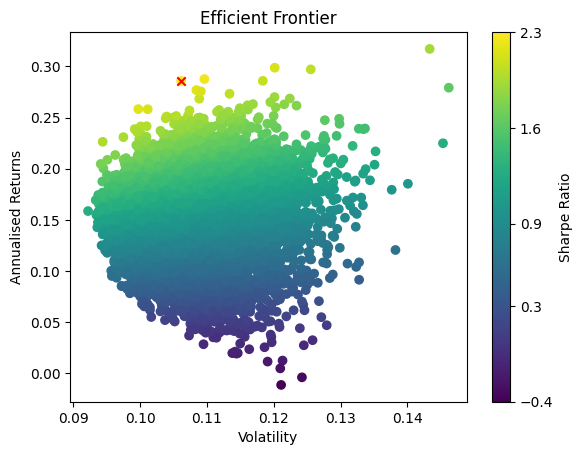

In [383]:
test.plot()

In [384]:
test.getWeights()

AZN.L: 8.1%
BARC.L: 20.5%
BATS.L: 18.4%
BP.L: 0.4%
DGE.L: 2.4%
GSK.L: 0.4%
HSBA.L: 0.1%
LSEG.L: 17.3%
REL.L: 22.1%
RIO.L: 6.5%
SHEL.L: 3.8%


In [385]:
test.getOptimalResults()

Sharpe Ratio: 2.32
Expected Annualised Return: 28.6%
Volatility: 0.11
